In [82]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import sys
import pickle
from sklearn.externals import joblib 
from pdpbox import pdp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from processing_scripts import model_utils 

# define folder where data resides 
DATAFOLDER = "~/Documents/data-science-coursework/nyu-ml/project/"

In [2]:
# import data 
appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/appeals_data_final.csv'))
non_appeals = pd.read_csv(os.path.join(DATAFOLDER, 'data_for_model/non_appeals_data_final.csv'))

In [3]:
# combine appeals and non-appeals 
combined = pd.concat([appeals, non_appeals]) 
combined['appealed'] = np.where(combined['idnproceeding'].isin(appeals['idnproceeding']), 1, 0)
combined['appealed'].value_counts().sort_index()

0    128720
1    242466
Name: appealed, dtype: int64

# Exploratory Data Analysis  

Correlate appeal grant rate with various features 

In [4]:
def plot_feature(df, feature_list, feature_name, 
                 min_samples=None, limit_range=None, limit_values=None, limit_top_n=None, sort_by='index'): 
    """ Plots the average grant rate and number of appeals by feature / list of features """
    x = df.groupby(feature_list)['granted'].agg(['size', np.mean])
    if limit_range is not None: 
        x = x[(x.index >= limit_range[0]) & (x.index <= limit_range[1])]
    if limit_values is not None: 
        x = x[x.index.isin(limit_values)]
    if limit_top_n is not None: 
        x = x.sort_values(by='size', ascending=False)[:limit_top_n]
    if min_samples is not None: 
        x = x[x['size'] >= min_samples] 
    if sort_by == 'index': 
        x = x.sort_index(ascending=True)
    elif sort_by == 'size':
        x = x.sort_values(by='size', ascending=False)
    elif sort_by == 'mean-high-low':
        x = x.sort_values(by='mean', ascending=False)
    elif sort_by == 'mean-low-high':
        x = x.sort_values(by='mean', ascending=True)
    else: 
        raise Exception("Invalid sort_by argument (valid options include: 'index', 'size, 'mean-high-low', 'mean-low-high'!")
    xn = range(len(x))
    fig, ax1 = plt.subplots(figsize=(16, 5))
    ax2 = ax1.twinx()  # set up the 2nd axis
    ax1.plot(xn, x['mean'], label='Avg Grant Rate') #plot the Revenue on axis #1
    ax2.bar(xn, x['size'], alpha=0.2, color='gray', label='Number of Appeals')
    ax2.grid(b=False)
    ax1.set_title('Average Grant Rate and Number of Appeals by {}'.format(feature_name))
    ax1.set_ylabel('Appeal Grant Rate')
    ax2.set_ylabel('Number of Appeals')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')    
    plt.xticks(xn, x.index)
    return x 

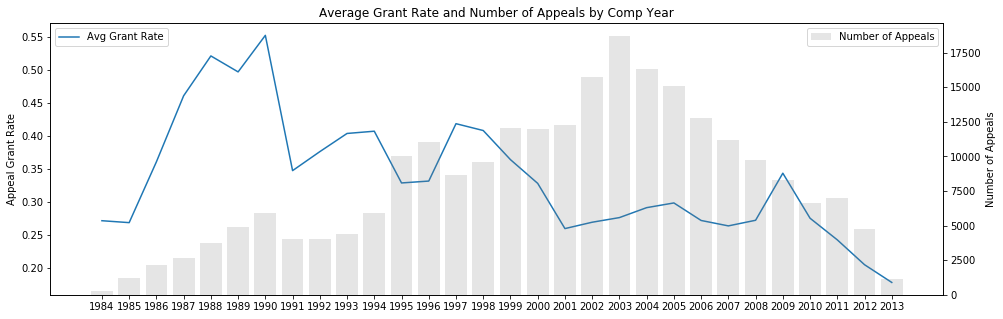

In [5]:
# steep plunge in 1991 
comp_year = plot_feature(appeals, ['comp_year'], 'Comp Year', limit_range=(1984, 2014)); 

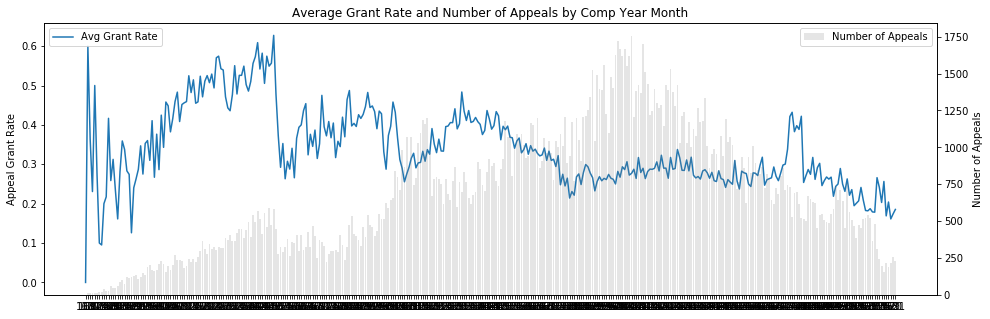

In [6]:
# steep plunge in 1991 (year-month view)
comp_year_month = plot_feature(appeals, ['comp_year_month'], 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

In [7]:
# plunge occured on month 253 (=1991 January)
comp_year_month[(comp_year_month.index >= (1990-1970)*12 + 6)  & (comp_year_month.index < (1992-1970)*12)]

,size,mean
comp_year_month,,
246,554,0.505415
247,463,0.574514
248,590,0.549153
249,476,0.556723
250,585,0.627350
251,448,0.477679
252,274,0.372263
253,325,0.292308
254,292,0.352740


In [8]:
# there was another steep dip on month 375 (March 2001)
comp_year_month[(comp_year_month.index >= (2001-1970)*12) & (comp_year_month.index < (2002-1970)*12)]

,size,mean
comp_year_month,,
372,780,0.312821
373,1043,0.294343
374,1000,0.322000
375,1089,0.247934
376,1012,0.274704
377,1208,0.245033
378,895,0.264804
379,938,0.214286
380,1170,0.230769


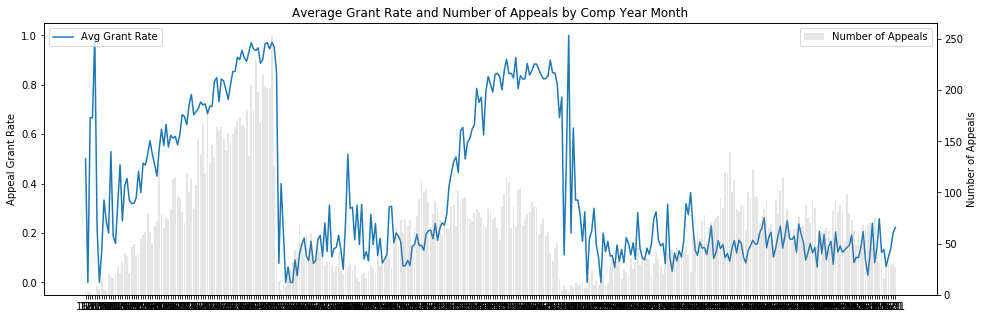

In [9]:
# turns out both were due to El Salvador 
comp_year_month_el_salv = plot_feature(appeals[appeals['nat_grouped'] == 'EL SALVADOR'], 
                                       'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

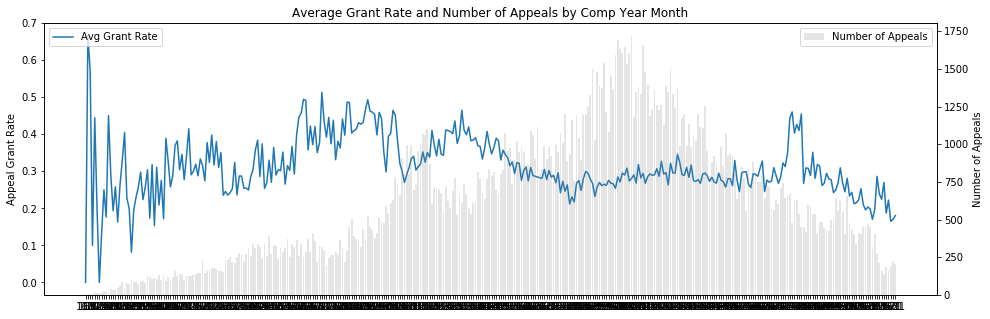

In [10]:
# with el salvador removed, the chart looks much smoother 
comp_year_month_not_el_salv = plot_feature(appeals[appeals['nat_grouped'] != 'EL SALVADOR'], 
                                           'comp_year_month', 'Comp Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

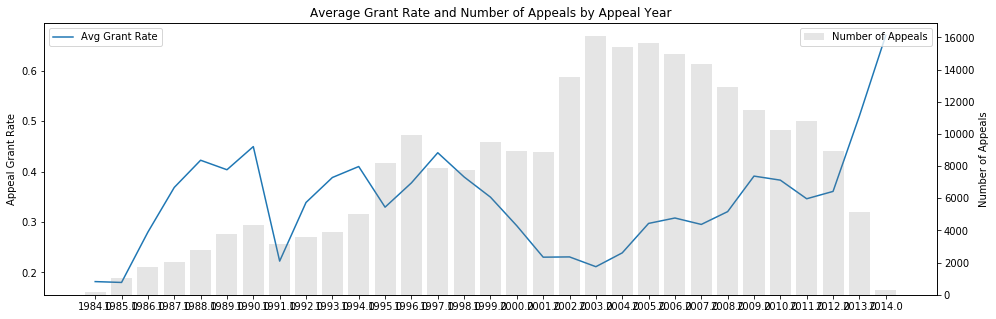

In [11]:
# beginning late 2013, there are fewer appeals, and appeals were increasingly likely to be successful 
# possibly relates to the 2014 decision that all asylum cases are entitled to a hearing before their claims can be rejected 
appeal_year = plot_feature(appeals, ['datAppealFiled_year'], 'Appeal Year', limit_range=(1984, 2014)); 

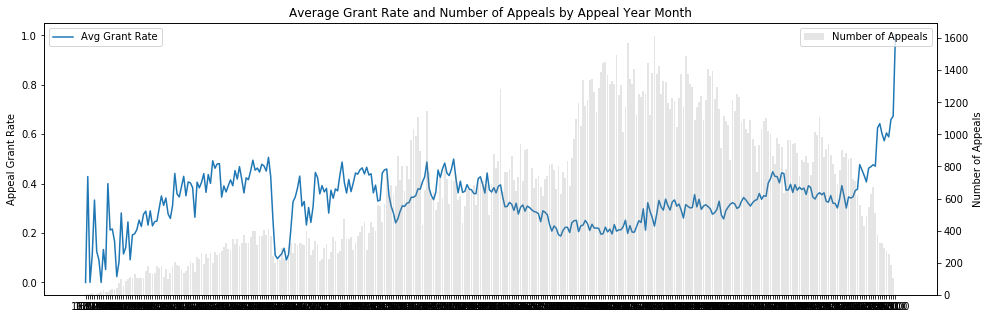

In [12]:
appeal_year_month = plot_feature(appeals, ['datAppealFiled_year_month'], 'Appeal Year Month', limit_range=(168, 540)); # 168 corresponds to 1984 month 1

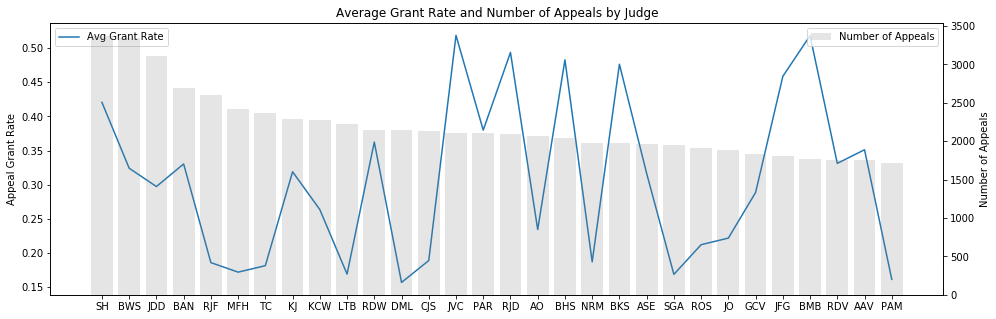

In [13]:
# appeal grant rate do vary substantially with judge 
judge = plot_feature(appeals, ['ij_code_grouped'], 'Judge', limit_top_n=30, sort_by='size'); 

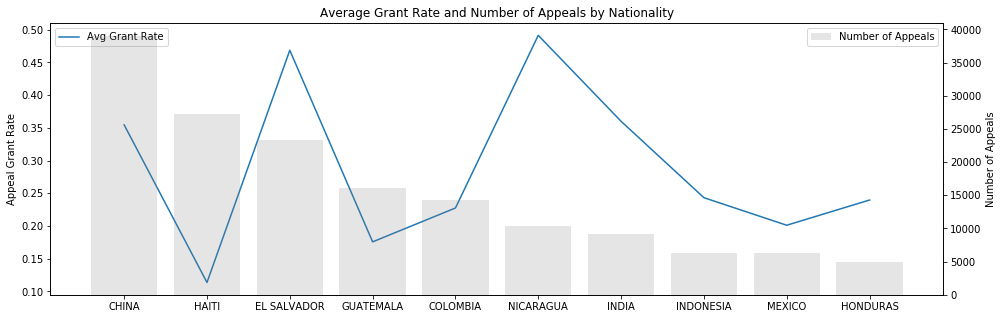

In [14]:
nat = plot_feature(appeals, ['nat_grouped'], 'Nationality', limit_top_n=10, sort_by='size'); 

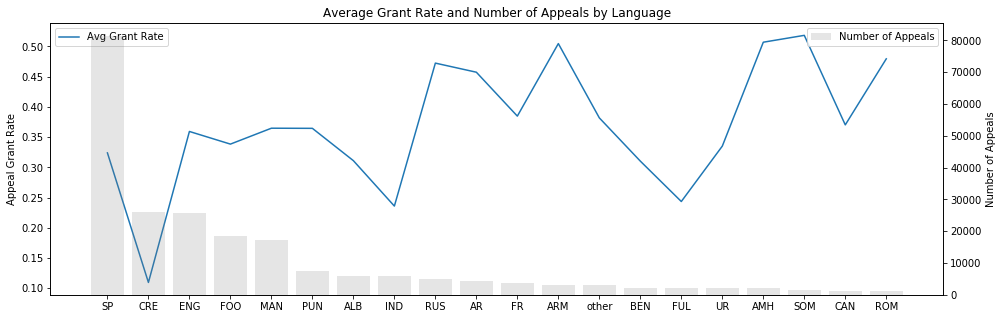

In [15]:
lang = plot_feature(appeals, ['lang_grouped'], 'Language', limit_top_n=20, sort_by='size');  

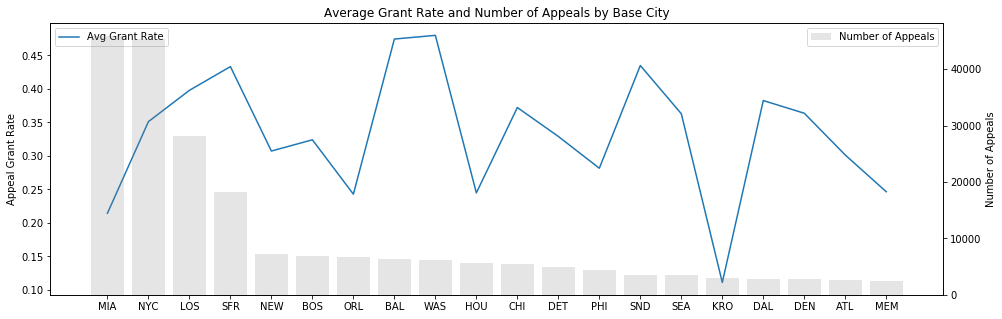

In [16]:
base_city = plot_feature(appeals, ['base_city_code'], 'Base City', limit_top_n=20, sort_by='size');  

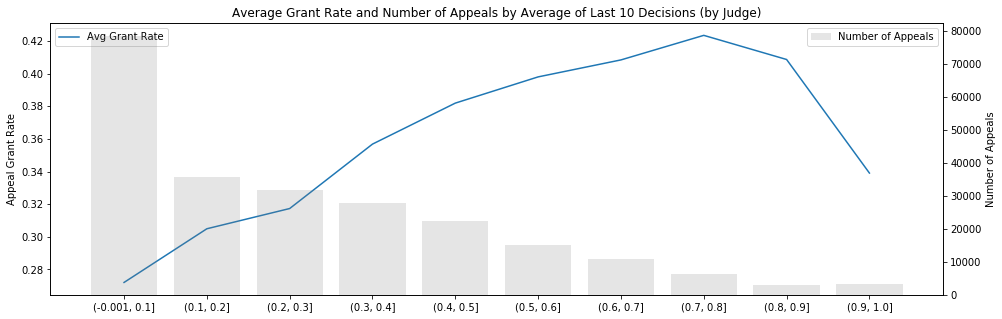

In [17]:
# not surprisingly the average appeal decision over last 10 cases for a judge was highly predictive of its next 
appeals['last_10_appeal_grant_by_judge_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_bin'], 
                             'Average of Last 10 Decisions (by Judge)', sort_by='index');  

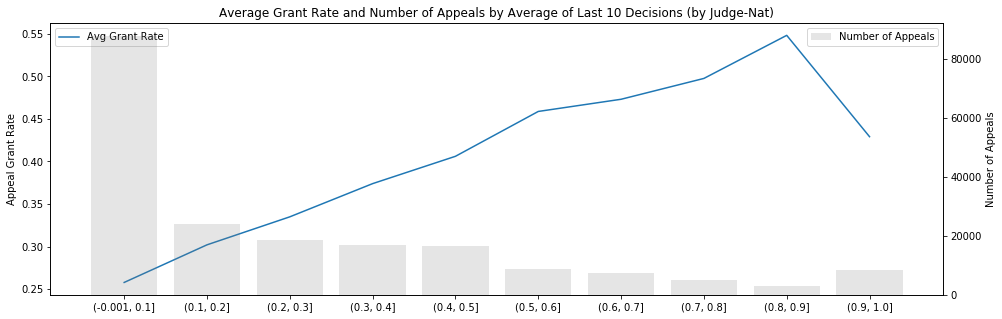

In [18]:
# even stronger effect at the judge-nat level 
appeals['last_10_appeal_grant_by_judge_nat_bin'] = pd.cut(appeals['last_10_appeal_grant_by_judge_nat'], bins=10)
last_10_judge = plot_feature(appeals, ['last_10_appeal_grant_by_judge_nat_bin'], 
                             'Average of Last 10 Decisions (by Judge-Nat)', sort_by='index');  

# Predict on Non-Appeals (and appeals)

Had denied respondents appealed, what % would have been successful? 

In [19]:
# features used 
FULL_CAT_FEATURES = ['nat_grouped', 'ij_code_grouped', 'lang_grouped', 'case_type_string', 'Male_judge',
                     'strCustody', 'strProbono', 'original_dec_string', 'base_city_code', 'hearing_loc_match_base']
FULL_NUM_FEATURES = ['datAppealFiled_year', 'comp_year_month', 'lawyer', 'defensive', 'affirmative',
                     'oral', 'written', 'comp_year', 'Year_Appointed_SLR', 'Year_College_SLR',
                     'Year_Law_school_SLR', 'Government_Years_SLR', 'Govt_nonINS_SLR', 'INS_Years_SLR', 
                     'Military_Years_SLR', 'NGO_Years_SLR', 'Privateprac_Years_SLR', 'Academia_Years_SLR',
                     'judge_missing_bio', 'appeal_days_elapsed_since_comp_date', 'comp_days_elasped_since_input_date', 
                     'input_days_elapsed_since_osc_date', 'years_since_judge_appointment', 'years_since_law_school', 
                     'last_10_appeal_grant_by_judge', 'last_10_appeal_grant_by_judge_nat'] 
FULL_IMPUTE_METHODS = {'nat_grouped': 'none', 'strCustody': 'none', 'strProbono': 'none', 'Male_judge': 'none', 
                       'original_dec_string': 'none', 'defensive': 'zero', 'affirmative': 'zero', 'oral': 'zero', 
                       'written': 'zero', 'Year_Appointed_SLR': 'median', 'Year_College_SLR': 'median',
                       'Year_Law_school_SLR': 'median', 'Government_Years_SLR': 'median', 
                       'Govt_nonINS_SLR': 'median', 'INS_Years_SLR': 'median', 'Military_Years_SLR': 'median',
                       'NGO_Years_SLR': 'median', 'Privateprac_Years_SLR': 'median', 'Academia_Years_SLR': 'median',
                       'last_10_appeal_grant_by_judge': 'median', 'last_10_appeal_grant_by_judge_nat': 'median'} 

#### Predict using sequential models  

In [20]:
# restrict data to those where appeal_days_elapsed_since_comp_date = 28 +/- 2 days 
# to reduce comparison bias since we filled all non-appeals with that median (28)
# combined = combined[(combined['appeal_days_elapsed_since_comp_date'] >= 25) & (combined['appeal_days_elapsed_since_comp_date'] <= 29)]
# combined['appealed'].value_counts().sort_index()

In [21]:
# load sequential(w) models from pickle 
# (WARNING: this unpickles 20 random forest models at once and might pose memory issues on smaller local machines)

seq_model_pkl_fname = "sequential_random_forest_vF.pkl"
sequential_models = joblib.load(seq_model_pkl_fname) 
# with open(seq_model_pkl_fname, "rb") as f:
#     sequential_models = pickle.load(f, encoding='latin1') 

In [22]:
def sequential_model_prediction(df, appeals_df, cat_features, num_features, impute_methods, sequential_models): 
    """ Use sequential models to predict each year's outcomes  """
        
    # initialize empty dictionary to collect all results 
    sequential_predictions = []
    
    for i, year in enumerate(np.arange(1994, 2014, 1)): 
        _, X_test, _, _ = model_utils.get_model_data_by_year(
            df, appeals_df, label=None, unique_id='idnproceeding', cat_features=cat_features, 
            num_features=num_features, impute_methods = impute_methods, predict_year=year) 
        
        # run and append predictions 
        model = sequential_models[i]
        pred = pd.Series(data=model.predict(X_test), index=X_test.index.tolist())
        sequential_predictions.append(pred)
    
    return pd.DataFrame(pd.concat(sequential_predictions), columns=['pred']) 

In [23]:
sequential_predictions = sequential_model_prediction(df=combined, appeals_df=appeals,cat_features=FULL_CAT_FEATURES, 
                                                     num_features=FULL_NUM_FEATURES, impute_methods=FULL_IMPUTE_METHODS, 
                                                     sequential_models=sequential_models)

['case_type_string'] have missing values with no imputation method specified. 
            By default, they have been filled with 'None'.


In [24]:
combined_pred = combined.merge(sequential_predictions, how='inner', left_on='idnproceeding', right_index=True) 
combined_pred_summary = combined_pred.groupby(['appealed', 'pred']).size().unstack()
print("Model predicted only {:.1f}% of denied respondents who didn't appeal, would have been successful had they appealed.".format(
    100 * float(combined_pred_summary.iloc[0][1]) / combined_pred_summary.iloc[0].sum()))
print("This means {:.1f}% of those predicted to be successful did actually appeal after all.".format(
    100 * float(combined_pred_summary.iloc[1][1]) / combined_pred_summary[1].sum()))
combined_pred_summary

Model predicted only 6.4% of denied respondents who didn't appeal, would have been successful had they appealed.
This means 84.3% of those predicted to be successful did actually appeal after all.


pred,0,1
appealed,,
0,104865,7164
1,177128,38435


#### Double Check with Aggregate Model 

In [71]:
# load aggregate model from pickle 
model_pkl_fname = "aggregate_random_forest_vF.pkl"
with open(model_pkl_fname, 'rb') as f:  
    agg_model = pickle.load(f)

In [72]:
# subset and convert non appeals data to X 
non_appeals_X = model_utils.transform_features(non_appeals[FULL_CAT_FEATURES + FULL_NUM_FEATURES], 
                                               appeals[FULL_CAT_FEATURES + FULL_NUM_FEATURES], 
                                               cat_features=FULL_CAT_FEATURES, num_features=FULL_NUM_FEATURES, 
                                               impute_methods=FULL_IMPUTE_METHODS)
non_appeals_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128720 entries, 0 to 128719
Columns: 704 entries, datAppealFiled_year to hearing_loc_match_base:::missing_info
dtypes: float64(26), uint8(678)
memory usage: 108.8 MB


In [73]:
agg_pred = agg_model.predict(non_appeals_X)
print("""Aggregate model predicts of the {} denied respondents that didn't appeal, {} ({:.1f}%) would have 
been successful had they appealed.""".format(len(agg_pred), sum(agg_pred), 100 * float(agg_pred.sum()) / len(agg_pred)))

Aggregate model predicts of the 128720 denied respondents that didn't appeal, 13117 (10.2%) would have 
been successful had they appealed.


Were there any groups that "under-appeal"? We examine this by looking at the proportion of "likely successes" that didn't appeal (pred=1 & appeal=0)? 

In [25]:
likely_successes = combined_pred[combined_pred['pred'] == 1].copy() 
likely_successes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45599 entries, 16 to 128693
Data columns (total 46 columns):
Academia_Years_SLR                     42892 non-null float64
Government_Years_SLR                   42892 non-null float64
Govt_nonINS_SLR                        42892 non-null float64
INS_Years_SLR                          42892 non-null float64
Male_judge                             42892 non-null float64
Military_Years_SLR                     42892 non-null float64
NGO_Years_SLR                          42892 non-null float64
Privateprac_Years_SLR                  42892 non-null float64
Year_Appointed_SLR                     42892 non-null float64
Year_College_SLR                       42892 non-null float64
Year_Law_school_SLR                    42892 non-null float64
affirmative                            45244 non-null float64
appeal_days_elapsed_since_comp_date    45599 non-null float64
base_city_code                         45599 non-null object
case_type_string      

In [26]:
likely_successes.groupby(['base_city_code'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
base_city_code,,
NYC,9708,0.878657
LOS,7943,0.821226
SFR,5120,0.910742
MIA,4764,0.882452
WAS,2286,0.751531
BAL,1754,0.777081
CHI,1203,0.860349
SND,1194,0.774707
NEW,1004,0.858566


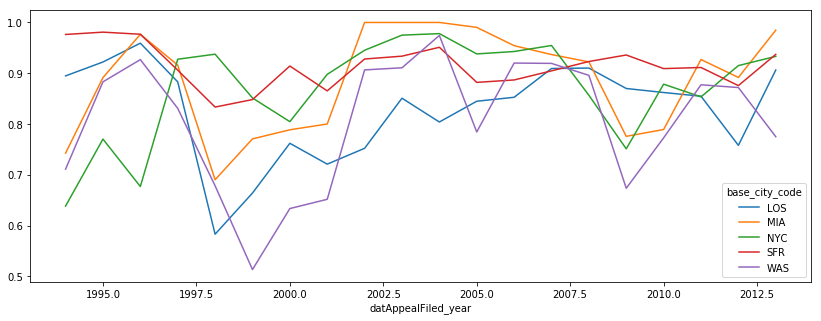

In [27]:
top_base = likely_successes['base_city_code'].value_counts().sort_values(ascending=False)[:5].index
base_ts = likely_successes[likely_successes['base_city_code'].isin(top_base)].groupby(
    ['datAppealFiled_year', 'base_city_code'])['appealed'].mean().unstack()
base_ts.plot(figsize=(14, 5))

In [28]:
likely_successes.groupby(['ij_code_grouped'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
ij_code_grouped,,
SH,1105,0.876018
JVC,832,0.789663
BHS,709,0.866008
BWS,681,0.929515
JS,657,0.544901
BKS,652,0.930982
WI,620,0.685484
PAR,563,0.774423
RW,539,0.870130


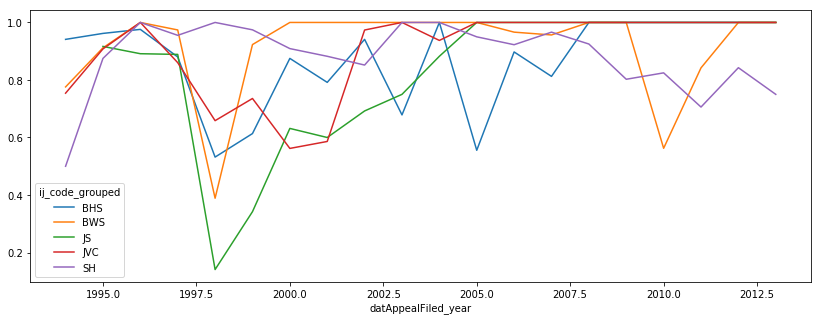

In [29]:
top_judge = likely_successes['ij_code_grouped'].value_counts().sort_values(ascending=False)[:5].index
judge_ts = likely_successes[likely_successes['ij_code_grouped'].isin(top_judge)].groupby(
    ['datAppealFiled_year', 'ij_code_grouped'])['appealed'].mean().unstack()
judge_ts.plot(figsize=(14, 5))

In [30]:
likely_successes.groupby(['nat_grouped'])['appealed'].agg(['size', np.mean]).sort_values('size', ascending=False)[:20]

,size,mean
nat_grouped,,
CHINA,8869,0.902244
EL SALVADOR,5302,0.776122
NICARAGUA,3725,0.885638
INDIA,2126,0.923330
ARMENIA,1235,0.895547
ETHIOPIA,1153,0.854293
COLOMBIA,1128,0.943262
GUATEMALA,995,0.787940
IRAQ,910,0.802198


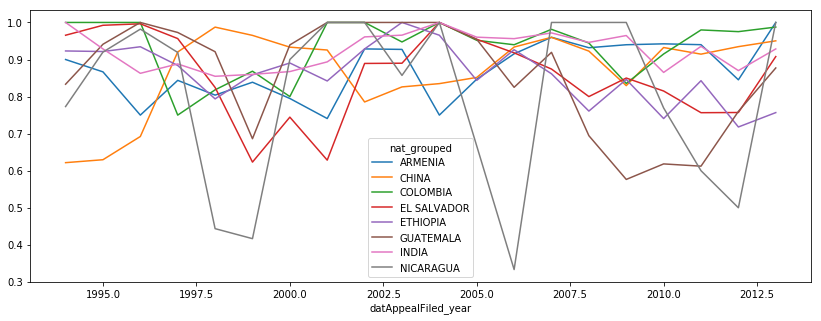

In [31]:
top_10_nat = likely_successes['nat_grouped'].value_counts().sort_values(ascending=False)[:8].index
nat_ts = likely_successes[likely_successes['nat_grouped'].isin(top_10_nat)].groupby(
    ['datAppealFiled_year', 'nat_grouped'])['appealed'].mean().unstack()
nat_ts.plot(figsize=(14, 5))

# Error Analysis

In model training notebook we noted that the sequential model performance in 2009 is particularly bad. Here we investigate why that might be the case.

In [32]:
appeal_pred = combined_pred[combined_pred['appealed'] == 1].copy() 
appeal_pred['correct'] = np.where(appeal_pred['pred'] == appeal_pred['granted'], 1, 0)
appeal_pred['correct'].value_counts()

1    157548
0     58015
Name: correct, dtype: int64

In [33]:
def assign_outcome(row): 
    """ Assigns outcome as True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
        based on prediction and truth values. """
    if row['pred'] == 1: 
        if row['granted'] == 1: 
            return 'TP'
        elif row['granted'] == 0: 
            return 'FP'
    elif row['pred'] == 0: 
        if row['granted'] == 1: 
            return 'FN'
        elif row['granted'] == 0:
            return 'TN'
    else: 
        return 'error'

appeal_pred['outcome'] = appeal_pred.apply(assign_outcome, axis=1)
appeal_pred['outcome'].value_counts()

TN    132958
FN     44170
TP     24590
FP     13845
Name: outcome, dtype: int64

In [34]:
# does not match model training - why? 
appeal_pred_summary = appeal_pred.groupby(['datAppealFiled_year', 'outcome']).size().unstack()
appeal_pred_summary['total'] = appeal_pred_summary.sum(axis=1)
appeal_pred_summary['FN_'] = appeal_pred_summary['FN'] / appeal_pred_summary['total']
appeal_pred_summary['FP_'] = appeal_pred_summary['FP'] / appeal_pred_summary['total']
appeal_pred_summary['TN_'] = appeal_pred_summary['TN'] / appeal_pred_summary['total']
appeal_pred_summary['TP_'] = appeal_pred_summary['TP'] / appeal_pred_summary['total']
appeal_pred_summary['Accuracy'] = appeal_pred_summary['TN_'] + appeal_pred_summary['TP_']
appeal_pred_summary

outcome,FN,FP,TN,TP,total,FN_,FP_,TN_,TP_,Accuracy
datAppealFiled_year,,,,,,,,,,
1994.0,1119,443,2516,937,5015,0.223131,0.088335,0.501695,0.186839,0.688534
1995.0,1474,523,4974,1226,8197,0.179822,0.063804,0.606807,0.149567,0.756374
1996.0,2061,614,5583,1698,9956,0.207011,0.061671,0.560767,0.170550,0.731318
1997.0,1810,818,3625,1643,7896,0.229230,0.103597,0.459093,0.208080,0.667173
1998.0,1884,702,4022,1127,7735,0.243568,0.090756,0.519974,0.145701,0.665676
1999.0,1644,951,5241,1679,9515,0.172780,0.099947,0.550815,0.176458,0.727273
2000.0,1414,618,5716,1204,8952,0.157954,0.069035,0.638517,0.134495,0.773012
2001.0,1486,372,6475,562,8895,0.167060,0.041821,0.727937,0.063182,0.791119
2002.0,2508,540,9867,614,13529,0.185380,0.039914,0.729322,0.045384,0.774706


In [49]:
# error rate 
top_nat = appeal_pred['nat_grouped'].value_counts().sort_values(ascending=False)[:8].index
err_rate_by_year_by_nationality = appeal_pred[appeal_pred['nat_grouped'].isin(top_nat)].groupby(
    ['datAppealFiled_year', 'nat_grouped'])['granted'].agg([np.mean]).unstack()
err_rate_by_year_by_nationality

mean                                            \
nat_grouped             CHINA  COLOMBIA EL SALVADOR GUATEMALA     HAITI   
datAppealFiled_year                                                       
1994.0               0.362484  0.333333    0.182390  0.181230  0.048662   
1995.0               0.277992  0.391304    0.271298  0.101852  0.061141   
1996.0               0.443506  0.206897    0.326697  0.112733  0.061069   
1997.0               0.342857  0.370370    0.505440  0.144304  0.124764   
1998.0               0.330681  0.255814    0.754717  0.146572  0.101106   
1999.0               0.292141  0.300752    0.844846  0.131042  0.072660   
2000.0               0.219048  0.191617    0.830368  0.126255  0.052673   
2001.0               0.229527  0.130102    0.686084  0.144531  0.055745   
2002.0               0.264548  0.095382    0.426630  0.201878  0.073546   
2003.0               0.212656  0.089178    0.256927  0.159754  0.049566   
2004.0               0.306654  0.166898    0.254545  0.198171  0.067420   
2005.0               0.422468  0.258612    0.247563  0.197595  0.085366   
2006.0               0.377248  0.248573    0.236230  0.162123  0.092770   
2007.0               0.320110  0.250000    0.209395  0.151163  0.098890   
2008.0               0.335780  0.350802    0.234814  0.194043  0.122917   
2009.0               0.434294  0.338954    0.255837  0.297894  0.437993   
2010.0               0.474494  0.344227    0.236326  0.225630  0.575510   
2011.0               0.402536  0.342784    0.207028  0.222222  0.439024   
2012.0               0.468804  0.580420    0.212379  0.223275  0.354086   
2013.0               0.678059  0.755274    0.333333  0.321534  0.480874   

                                                   
nat_grouped             INDIA INDONESIA    MEXICO  
datAppealFiled_year                                
1994.0               0.348901  0.666667  0.117647  
1995.0               0.310112  0.250000  0.138298  
1996.0               0.369830  0.222222  0.076923  
1997.0               0.426136  1.000000  0.228070  
1998.0               0.432039  0.400000  0.187500  
1999.0               0.433269  0.105263  0.106707  
2000.0               0.395415  0.136364  0.148760  
2001.0               0.344262  0.164835  0.175299  
2002.0               0.407186  0.124277  0.115183  
2003.0               0.386216  0.171717  0.195455  
2004.0               0.405039  0.158676  0.200000  
2005.0               0.381786  0.154545  0.322884  
2006.0               0.443595  0.192857  0.288462  
2007.0               0.354298  0.275472  0.260870  
2008.0               0.348718  0.364026  0.393013  
2009.0               0.386441  0.378995  0.310714  
2010.0               0.370149  0.397802  0.243719  
2011.0               0.304786  0.335106  0.179259  
2012.0               0.342424  0.332016  0.157895  
2013.0               0.451389  0.431034  0.177829

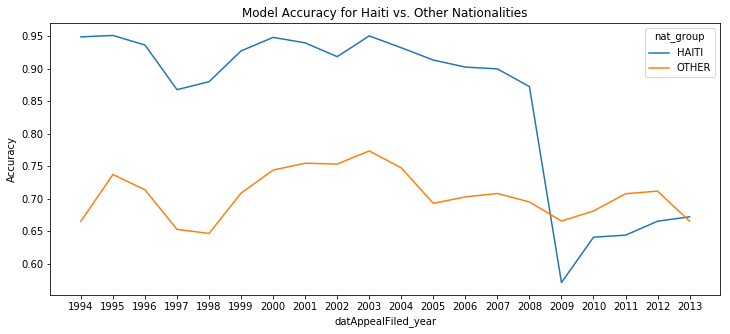

In [70]:
# plot error rate by haiti vs. other 
appeal_pred['nat_group'] = np.where(appeal_pred['nat_grouped'] == 'HAITI', 'HAITI', 'OTHER')
haiti_vs_rest = appeal_pred.groupby(['datAppealFiled_year', 'nat_group'])['correct'].mean().unstack() 
haiti_vs_rest.plot(figsize=(12, 5))
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Haiti vs. Other Nationalities')
plt.xticks(haiti_vs_rest.index);

# Partial Dependence Plots

In [83]:
def pdp_plot(model, X_train, feature, feature_is_cat=False, isolate_samples=10000, plot_samples=500, top_n=20, fi=None): 
    """
    Uses pdpbox package to plot partial dependence plot. Accepts trained classifier (model), X_train, 
    and feature name as inputs. Feature chosen may be categorical, in which case the function will retrieve 
    all the corresponding dummy variables. 
    """ 
    
    # pdp requires monotonically increasing or decreasing index 
    X_train = X_train.reset_index(drop=True)
    
    # if feature is categorical, 
    if feature_is_cat: 
        # generate list of dummy variable names
        plot_feature = [x for x in X_train.columns if feature + ':::' in x]
        # if too many dummy variables, limit to top_n by feature importance 
        if len(plot_feature) > top_n: 
            plot_feature = fi[plot_feature].sort_values(ascending=False)[:top_n].index.tolist() 
    else: 
        plot_feature = feature 

    # use pdpbox methods 
    pdp_isolate = pdp.pdp_isolate(model, X_train.sample(n=isolate_samples), plot_feature)
    pdp.pdp_plot(pdp_isolate, feature, plot_org_pts=True, plot_lines=True, center=False, frac_to_plot=plot_samples)

In [80]:
# regenerate train set as an input for pdp 
X_train, _, _, _ = model_utils.get_model_data(appeals, appeals, label='granted', cat_features = FULL_CAT_FEATURES, 
                                              num_features = FULL_NUM_FEATURES, impute_methods = FULL_IMPUTE_METHODS, 
                                              print_summary=True) 
fi = pd.Series(agg_model.feature_importances_, index=X_train.columns)

Training Data: (193972, 704) | Test Data: (48494, 704)


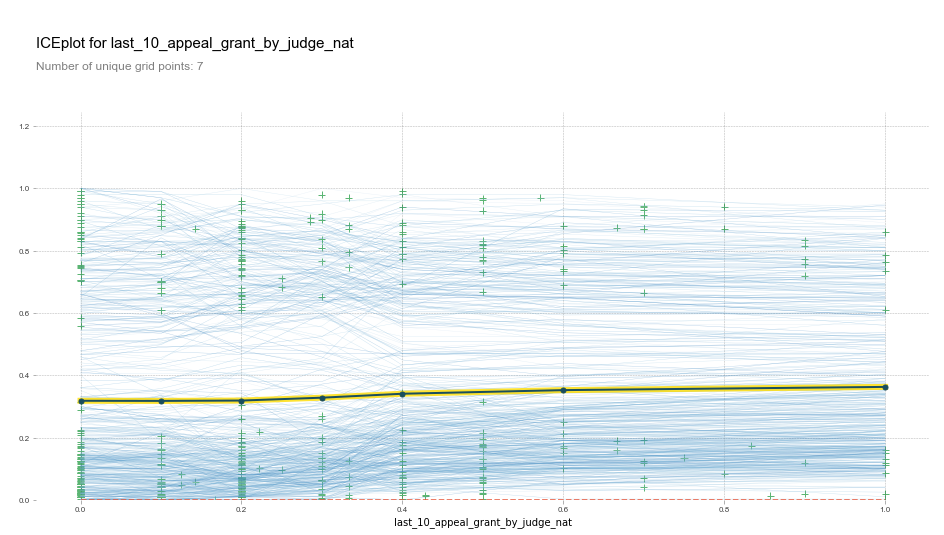

In [97]:
pdp_plot(agg_model, X_train, 'last_10_appeal_grant_by_judge_nat', feature_is_cat=False) 

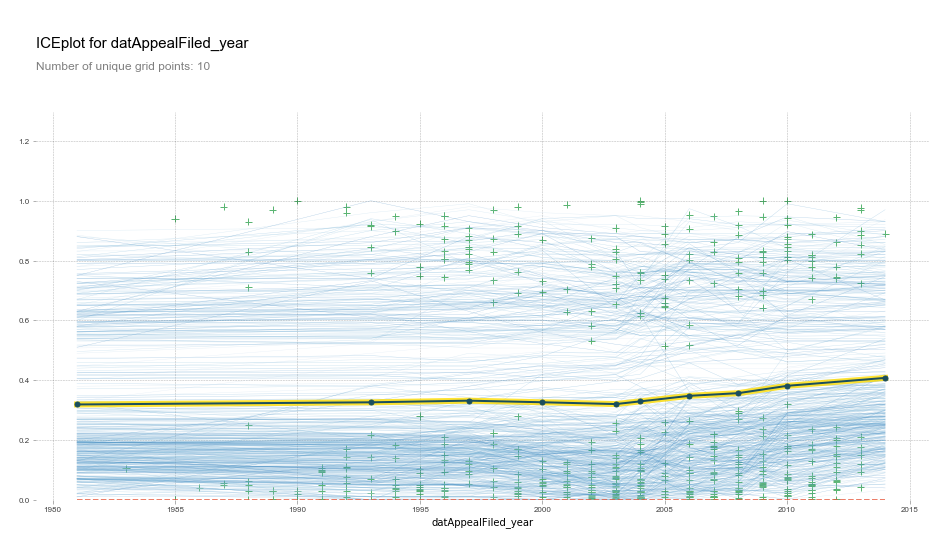

In [98]:
pdp_plot(agg_model, X_train, 'datAppealFiled_year', feature_is_cat=False) 

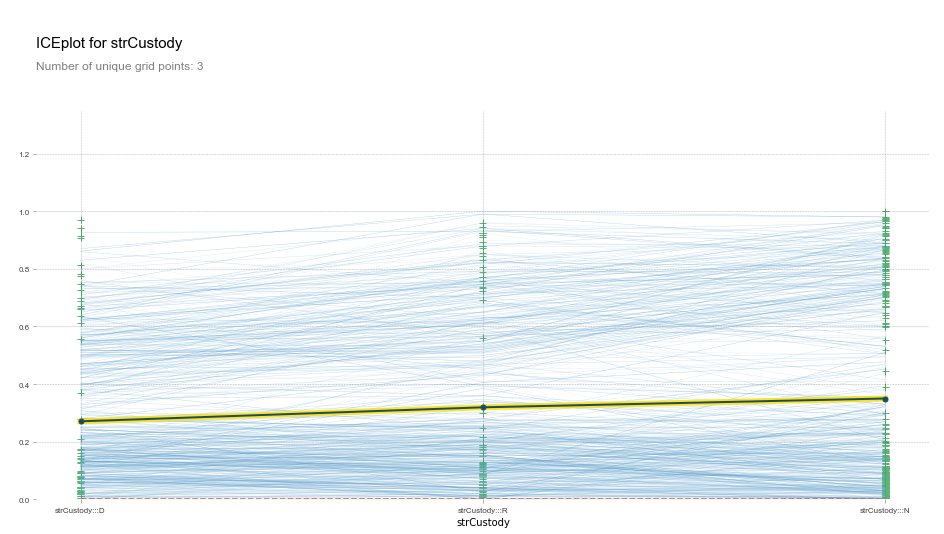

In [99]:
pdp_plot(agg_model, X_train, 'strCustody', feature_is_cat=True)

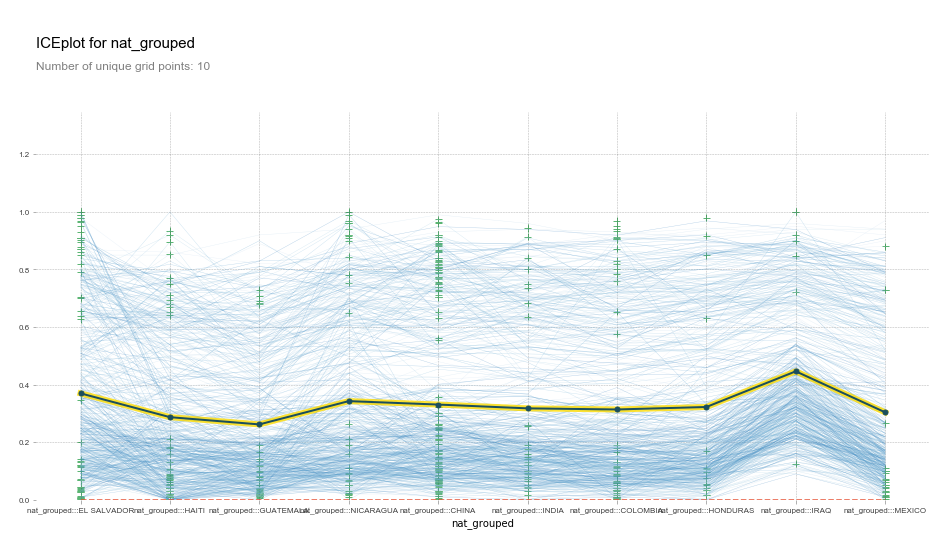

In [92]:
pdp_plot(agg_model, X_train, 'nat_grouped', feature_is_cat=True, isolate_samples=1000, plot_samples=500, top_n=10, fi=fi)

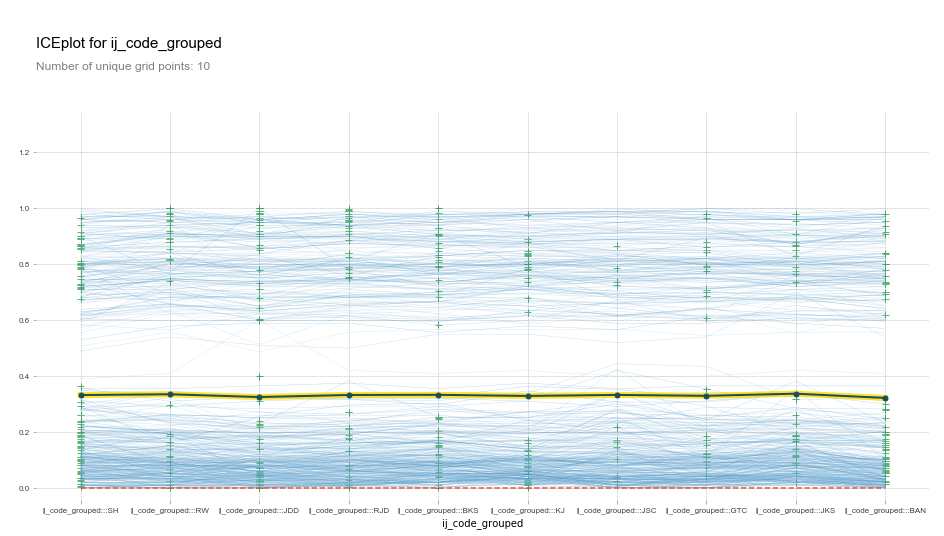

In [102]:
pdp_plot(agg_model, X_train, 'ij_code_grouped', feature_is_cat=True, isolate_samples=10000, plot_samples=500, top_n=10, fi=fi)